In [1]:
import json
import random

import numpy as np
from pysidt import Datum, MultiEvalSubgraphIsomorphicDecisionTree
from pysidt.decomposition import atom_decomposition_noH
from pysidt.plotting import plot_tree

from molecule.molecule import Group, Molecule, ATOMTYPES

In [2]:
with open("../data/rmgdbH298CHOstablenoringnoads.json", "r") as f:
    data = json.load(f)

In [3]:
training_data = []
for i, x in enumerate(data):
    d = Datum(Molecule().from_adjacency_list(x[0], check_consistency=True), x[1])
    dup = False
    for td in training_data:
        if td.mol.is_isomorphic(d.mol):
            dup = True
            break
    if not dup:
        training_data.append(d)

In [4]:
random.shuffle(training_data)
len(training_data)

184

In [5]:
train = training_data[:150]
test = []
test = training_data[150:]

In [6]:
root = Group().from_adjacency_list("""1 * R u0 px cx""")

sidt = MultiEvalSubgraphIsomorphicDecisionTree(
    atom_decomposition_noH,
    root_group=root,
    r=[ATOMTYPES[x] for x in ["C", "O"]],
    r_bonds=[1, 2, 3, 1.5],
    r_un=[0],
    fract_nodes_expand_per_iter=0.1,
)

In [8]:
sidt.generate_tree(data=train, validation_set=test, max_nodes=4)

TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'

In [ ]:
sidt.regularize(data=train, check_data=True)

In [ ]:
sidt.nodes

{'Root': Root -11523.246350435551,
 'Root_1R->C': Root_1R->C 25492.710244588823,
 'Root_N-1R->C': Root_N-1R->C -230276.66259207187,
 'Root_N-1R->C_Ext-1O-R': Root_N-1R->C_Ext-1O-R -8568.605796023663,
 'Root_N-1R->C_Ext-1O-R_2C->O': Root_N-1R->C_Ext-1O-R_2C->O 157094.05830960395,
 'Root_N-1R->C_Ext-1O-R_N-2C->O': Root_N-1R->C_Ext-1O-R_N-2C->O 91979.58163259874}

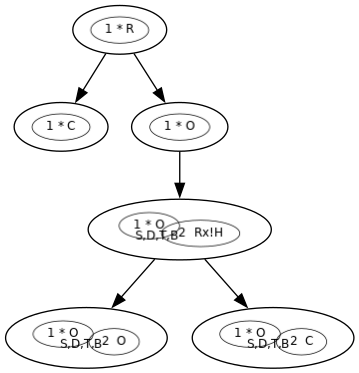

In [ ]:
plot_tree(sidt, images=True)

In [ ]:
train_error = [sidt.evaluate(d.mol) - d.value for d in train]
test_error = [sidt.evaluate(d.mol) - d.value for d in test]

In [ ]:
np.mean(np.abs(np.array(train_error))) / 4184.0

20.93896383060943

In [ ]:
np.mean(np.abs(np.array(test_error))) / 4184.0

20.411615377167276